In [1]:
import numpy as np

from statespace.models import NVMLangevinModel
from statespace.models import NVMConstantVelocityModel

from stochastic.processes import GammaProcess
from stochastic.processes import GeneralisedInverseGaussianProcess

from statespace.methods import KalmanFilter

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from primitive.linalg import invert_covariance

# Langevin model example:

In [3]:
T = np.linspace(0, 10, num=500).reshape(-1, 1)

In [4]:
# gamma_process_params = {"beta":10., "C":10.}
# subordinator = GammaProcess(**gamma_process_params)

In [5]:
gig_process_params = {"lam":-2.5, "gamma":0.01, "delta":0.2}
subordinator = GeneralisedInverseGaussianProcess(**gig_process_params)

Residual approximation mode is set to Gaussian approximation.
Simulation method is set to improved version.
Residual approximation method is set to lower bounding method.
Residual approximation mode is set to Gaussian approximation.
Residual approximation mode is set to Gaussian approximation.


In [6]:
# # student t
# lam = -2.5
# delta = np.sqrt(-2 * lam)

# gig_process_params = {"lam":lam, "gamma":0, "delta":delta}
# subordinator = GeneralisedInverseGaussianProcess(**gig_process_params)

In [7]:
langevin_model = NVMLangevinModel(subordinator=subordinator, theta=-1., mu=0., sigma=0.5, sigma_eps=0.01, shape=(2,1))

In [8]:
x, y = langevin_model.sample(times=T)

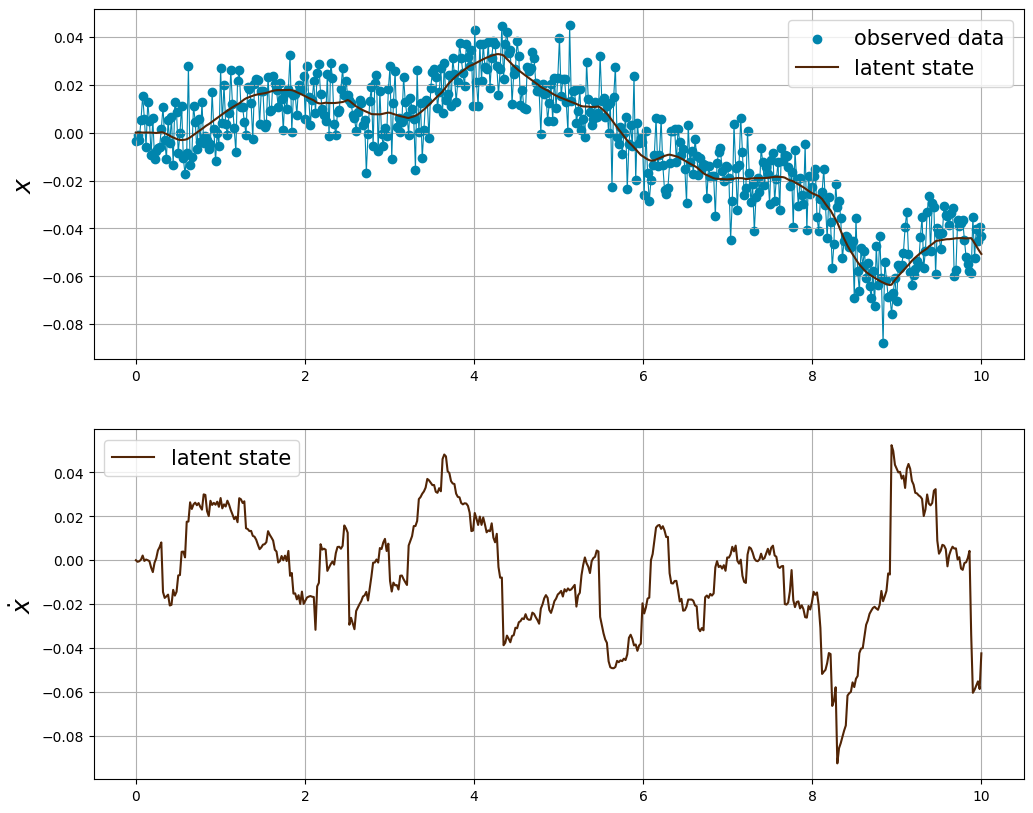

In [9]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

# Plot observations:
ax[0].scatter(T, y[:,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[:,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[:,0,:], color="#522506", label="latent state")
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[:,1,:], color="#522506", label="latent state")
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].grid(True)

plt.show()

In [10]:
langevin_model.get_parameter_values()

{'theta': -1.0, 'mu': 0.0, 'sigma': 0.5, 'sigma_eps': 0.01}

In [11]:
inference_method = KalmanFilter(model=langevin_model, prior=None, proposal=None)

The prior configuration is not valid.


In [12]:
# Initialise arrays
x_init = np.random.normal(loc=0., scale=0.1, size=(x[0].shape[0], 1))

P_init = np.random.normal(loc=0., scale=1., size=(x[0].shape[0], x[0].shape[0]))
P_init = np.matmul(P_init.T, P_init)

In [13]:
history = inference_method.filtering(times=T, y=y, x_init=x_init, P_init=P_init)

In [14]:
x_est_history = pd.DataFrame.from_records(history, columns=["mean"])["mean"]
P_est_history = pd.DataFrame.from_records(history, columns=["cov"])["cov"]

x_est = np.zeros(shape=(y.shape[0]+1, x_init.shape[0], 1))
P_est = np.zeros(shape=(y.shape[0]+1, P_init.shape[0], P_init.shape[1]))

for i in range(x_est_history.index.size):
    x_est[i] = x_est_history[i]
    P_est[i] = P_est_history[i]

In [15]:
vars = np.array([np.diag(COV) for COV in P_est[1:,:,:]])

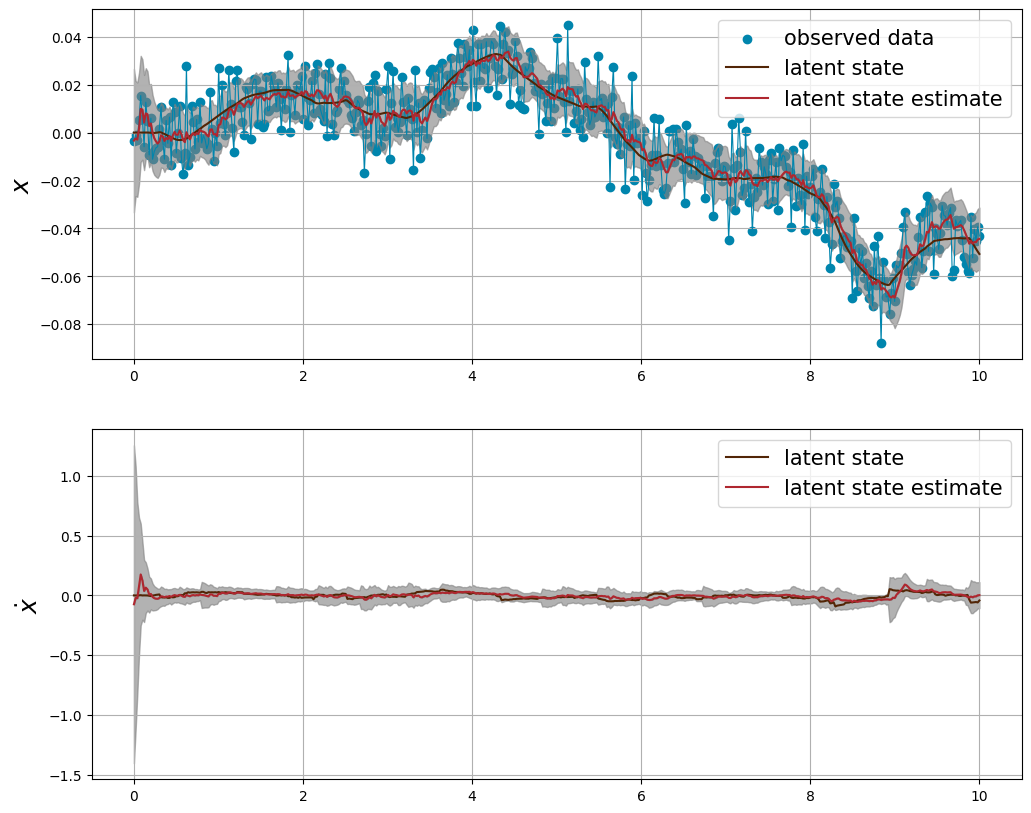

In [16]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

# Plot observations:
ax[0].scatter(T, y[:,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[:,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[:,0,:], color="#522506", label="latent state")

# Plot state estimate:
ax[0].plot(T, x_est[1:,0,:], color="#AF272F", label="latent state estimate")
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() + 3 * np.sqrt(vars[:, 0]), color='grey', alpha=0.6)
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() - 3 * np.sqrt(vars[:, 0]), color='grey', alpha=0.6)

# Settings:
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[:,1,:], color="#522506", label="latent state")

# Plot velocity state estimate:
ax[1].plot(T, x_est[1:,1,:], color="#AF272F", label="latent state estimate")
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() + 3 * np.sqrt(vars[:, 1]), color='grey', alpha=0.6)
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() - 3 * np.sqrt(vars[:, 1]), color='grey', alpha=0.6)

# Settings:
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].grid(True)

plt.show()

In [159]:
# Kalman filter:
D = 2
N = T.shape[0]

In [160]:
# Initialise arrays
x_init = np.random.normal(loc=0., scale=0.1, size=(D, 1))

P_init = np.random.normal(loc=0., scale=1., size=(D, D))
P_init = np.matmul(P_init.T, P_init)

# Initialise estimate
x_est = np.zeros(shape=(N+1, x_init.shape[0], 1))
x_pred = np.zeros(shape=(N, x_init.shape[0], 1))

P_est = np.zeros(shape=(N+1, P_init.shape[0], P_init.shape[1]))
P_pred = np.zeros(shape=(N, P_init.shape[0], P_init.shape[1]))

x_est[0] = x_init
P_est[0] = P_init

In [161]:
T_input = np.vstack((0, T))

In [162]:
H = np.zeros((1,2))
H[0][0] = 1

R = np.array([[0.01**2]])

In [163]:
# Start iterations:

for i, t in enumerate(T, 1):

    A = langevin_model.expA(t-T_input[i-1])
    noise_mean, Q = langevin_model.I.conditional_moments(s=T_input[i-1], t=t)

    # Predict:
    x_pred[i-1] = A @ x_est[i-1] + noise_mean
    P_pred[i-1] = A @ P_est[i-1] @ A.T + Q

    # Update:
    residual_pred = y[i-1] - H @ x_pred[i-1]
    residual_pred_cov = H @ P_pred[i-1] @ H.T + R
    kalman_gain = P_pred[i-1] @ H.T @ invert_covariance(residual_pred_cov)

    x_est[i] = x_pred[i-1] + kalman_gain @ residual_pred
    P_est[i] = (np.eye(D) - kalman_gain @ H) @ P_pred[i-1]

In [164]:
vars = np.array([np.diag(COV) for COV in P_est[1:,:,:]])

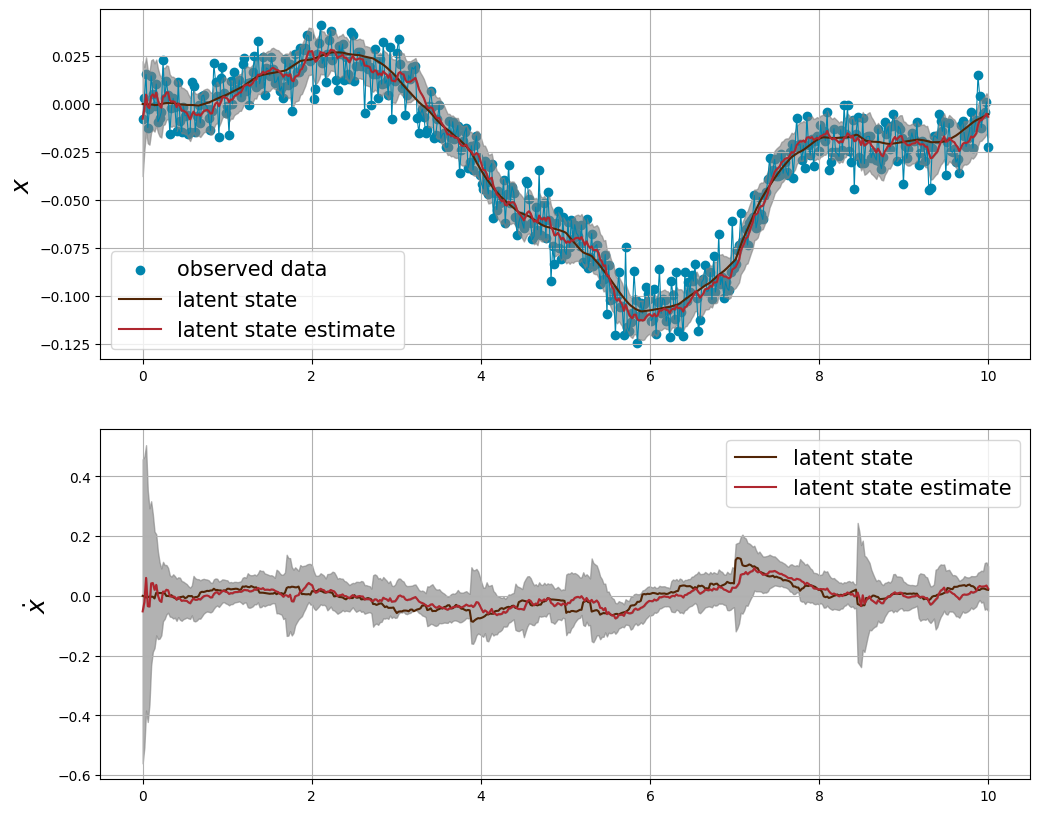

In [165]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

# Plot observations:
ax[0].scatter(T, y[:,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[:,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[:,0,:], color="#522506", label="latent state")

# Plot state estimate:
ax[0].plot(T, x_est[1:,0,:], color="#AF272F", label="latent state estimate")
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() + 3 * np.sqrt(vars[:, 0]), color='grey', alpha=0.6)
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() - 3 * np.sqrt(vars[:, 0]), color='grey', alpha=0.6)

# Settings:
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[:,1,:], color="#522506", label="latent state")

# Plot velocity state estimate:
ax[1].plot(T, x_est[1:,1,:], color="#AF272F", label="latent state estimate")
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() + 3 * np.sqrt(vars[:, 1]), color='grey', alpha=0.6)
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() - 3 * np.sqrt(vars[:, 1]), color='grey', alpha=0.6)

# Settings:
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].grid(True)

plt.show()

# Constant velocity model:

In [55]:
T = np.linspace(0, 50, num=500).reshape(-1, 1)

# gamma_process_params = {"beta":10., "C":10.}
# subordinator = GammaProcess(**gamma_process_params)

gig_process_params = {"lam":-1.5, "gamma":0.01, "delta":0.2}
subordinator = GeneralisedInverseGaussianProcess(**gig_process_params)

constant_velocity_model = NVMConstantVelocityModel(subordinator=subordinator, mu=0., sigma=1., sigma_eps=0.1, shape=(2,1))

Residual approximation mode is set to Gaussian approximation.
Simulation method is set to improved version.
Residual approximation method is set to lower bounding method.
Residual approximation mode is set to Gaussian approximation.
Residual approximation mode is set to Gaussian approximation.


In [56]:
x, y = constant_velocity_model.sample(times=T)

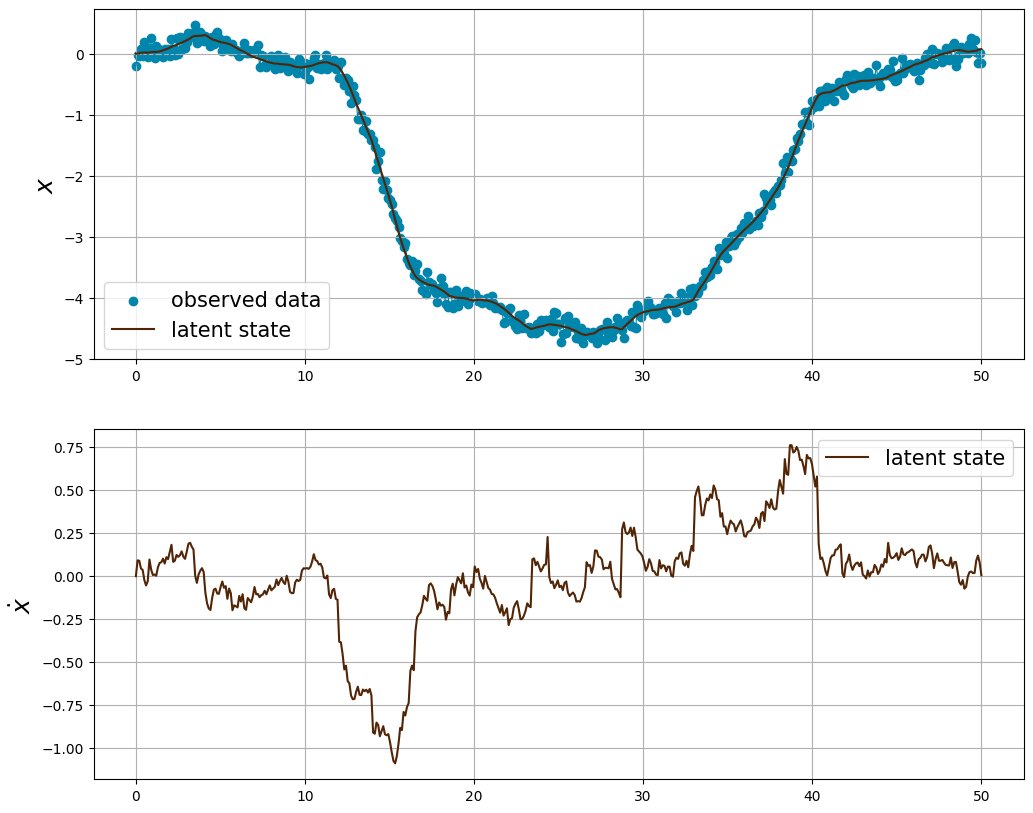

In [57]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

# Plot observations:
ax[0].scatter(T, y[:,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[:,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[:,0,:], color="#522506", label="latent state")
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[:,1,:], color="#522506", label="latent state")
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].grid(True)

plt.show()

In [58]:
constant_velocity_model.get_parameter_values()

{'mu': 0.0, 'sigma': 1.0, 'sigma_eps': 0.1}

In [59]:
# Kalman filter:
D = 2
N = T.shape[0]

In [60]:
# Initialise arrays
x_init = np.random.normal(loc=0., scale=1., size=(D, 1))

P_init = np.random.normal(loc=0., scale=1., size=(D, D))
P_init = np.matmul(P_init.T, P_init)

# Initialise estimate
x_est = np.zeros(shape=(N+1, x_init.shape[0], 1))
x_pred = np.zeros(shape=(N, x_init.shape[0], 1))

P_est = np.zeros(shape=(N+1, P_init.shape[0], P_init.shape[1]))
P_pred = np.zeros(shape=(N, P_init.shape[0], P_init.shape[1]))

x_est[0] = x_init
P_est[0] = P_init

In [61]:
T_input = np.vstack((0, T))

In [62]:
H = np.zeros((1,2))
H[0][0] = 1

R = np.array([[0.01]])

In [63]:
# Start iterations:

for i, t in enumerate(T, 1):

    A = langevin_model.expA(t-T_input[i-1])
    noise_mean, Q = langevin_model.I.conditional_moments(s=T_input[i-1], t=t)

    # Predict:
    x_pred[i-1] = A @ x_est[i-1] + noise_mean
    P_pred[i-1] = A @ P_est[i-1] @ A.T + Q

    # Update:
    residual_pred = y[i-1] - H @ x_pred[i-1]
    residual_pred_cov = H @ P_pred[i-1] @ H.T + R
    kalman_gain = P_pred[i-1] @ H.T @ invert_covariance(residual_pred_cov)

    x_est[i] = x_pred[i-1] + kalman_gain @ residual_pred
    P_est[i] = (np.eye(D) - kalman_gain @ H) @ P_pred[i-1]

In [64]:
vars = np.array([np.diag(COV) for COV in P_est[1:,:,:]])

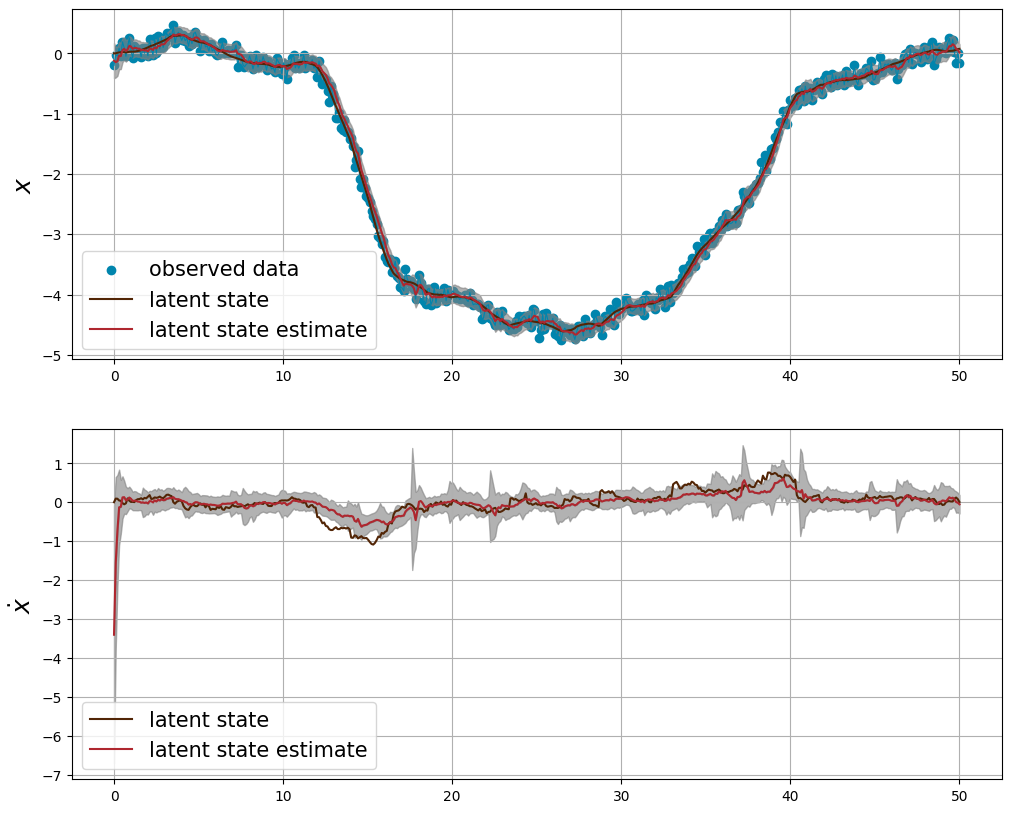

In [65]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

# Plot observations:
ax[0].scatter(T, y[:,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[:,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[:,0,:], color="#522506", label="latent state")

# Plot state estimate:
ax[0].plot(T, x_est[1:,0,:], color="#AF272F", label="latent state estimate")
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() + 3 * np.sqrt(vars[:, 0]), color='grey', alpha=0.6)
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() - 3 * np.sqrt(vars[:, 0]), color='grey', alpha=0.6)

# Settings:
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[:,1,:], color="#522506", label="latent state")

# Plot velocity state estimate:
ax[1].plot(T, x_est[1:,1,:], color="#AF272F", label="latent state estimate")
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() + 3 * np.sqrt(vars[:, 1]), color='grey', alpha=0.6)
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() - 3 * np.sqrt(vars[:, 1]), color='grey', alpha=0.6)

# Settings:
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].grid(True)

plt.show()